In [1]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

In [2]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [3]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [4]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100]
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1]
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    # sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

In [5]:
df_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_saact.pq")
merged_ldms_gputil = preprocess_data(df_gputil, df_sacct_gputil, metric="gpu_utilization", percentage=True)

Number of LDMS data points before preprocessing:  116803958
Number of LDMS data points after preprocessing:  85987227


In [6]:
jobs_with_g = merged_ldms_gputil[merged_ldms_gputil["Account"].str.contains("_g")]

In [7]:
jobs_without_g = merged_ldms_gputil[~merged_ldms_gputil["Account"].str.contains("_g")]

### Difference in GPU partition and CPU partition

- Most jobs run on the GPU partition. Therefore, we will focus on the GPU partition.

In [8]:
print("Number of jobs that use the GPU partition: ", len(jobs_with_g["jobid"].unique()))
print("Number of jobs that do not use the GPU partition: ", len(jobs_without_g["jobid"].unique()))

Number of jobs that use the GPU partition:  16144
Number of jobs that do not use the GPU partition:  942


### Frequency of different job states

In [9]:
states_of_interest = ['COMPLETED', 'FAILED', 'CANCELLED']
unique_jobs = jobs_with_g.groupby('jobid')['state'].first()
state_counts = unique_jobs.value_counts().reindex(states_of_interest, fill_value=0)

print(state_counts)

COMPLETED    14008
FAILED         385
CANCELLED     1723
Name: state, dtype: int64


### Number of nodes used per job

- Distribution of the number of unique nodes used per job, with the y-axis on a logarithmic scale.
- The height of each bar represents the number of jobs that use a specific range of unique nodes.
- The x-axis is divided into bins that are factors of 16.
- The plot shows where jobs are concentrated in terms of node usage. <b> Most jobs use fewer nodes.

In [10]:
# Group by jobid and count unique ProducerName for each job
node_counts = jobs_with_g.groupby('jobid')['ProducerName'].nunique().reset_index(name='unique_nodes')
display(node_counts)

,jobid,unique_nodes
0,13637517,1
1,13637520,1
2,13829694,69
3,13889527,20
4,13889532,20
...,...,...
16139,14068349,1
16140,14068350,256
16141,14068352,1
16142,14068358,1


In [11]:
print(node_counts.unique_nodes.max())
print(node_counts[node_counts["unique_nodes"] == 1].count())

256
jobid           10477
unique_nodes    10477
dtype: int64


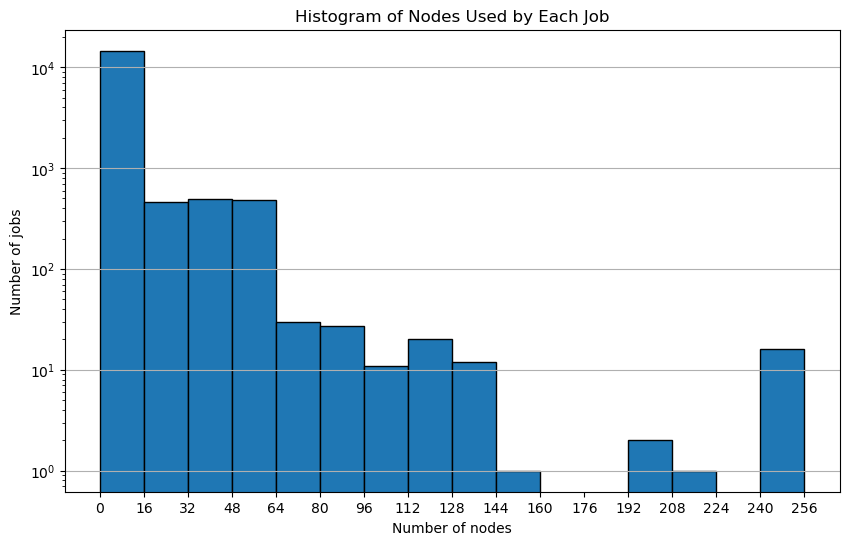

In [12]:
bins = list(range(0, 257, 16))  # Bins from 0 to 256, step by 16

plt.figure(figsize=(10, 6))
plt.hist(node_counts['unique_nodes'], bins=bins, edgecolor='black')
plt.title('Histogram of Nodes Used by Each Job')
plt.xlabel('Number of nodes')
plt.ylabel('Number of jobs')
plt.xticks(bins)  
plt.yscale('log') 
plt.grid(axis='y')
plt.show()

### Number of GPUs used per job

- Distribution of the number of GPUs used per job, with the y-axis on a logarithmic scale.
- The height of each bar represents the number of jobs that use a specific range of GPUs.
- The x-axis is divided into bins that are factors of 32.
- The plot shows where jobs are concentrated in terms of the number of GPUs. <b> Most jobs use fewer GPUs.

In [13]:
gpus_per_node = jobs_with_g.groupby(['jobid', 'ProducerName'])['gpu_id'].nunique().reset_index(name='gpus_per_node')
total_gpus_per_job = gpus_per_node.groupby('jobid')['gpus_per_node'].sum().reset_index(name='total_gpus')

In [14]:
print(total_gpus_per_job["total_gpus"].max())

1024


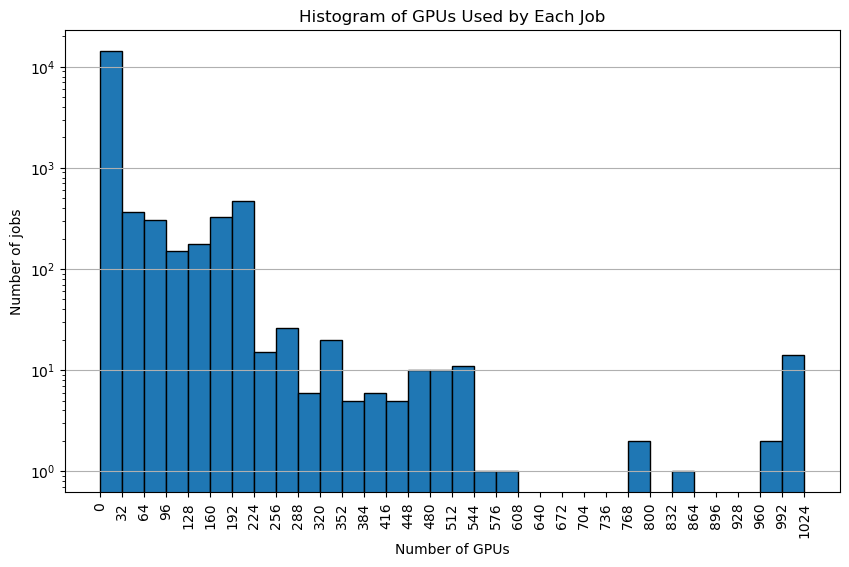

In [16]:
bins = list(range(0, 1025, 32))  # Bins from 0 to 256, step by 32

plt.figure(figsize=(10, 6))
plt.hist(total_gpus_per_job['total_gpus'], bins=bins, edgecolor='black')
plt.title('Histogram of GPUs Used by Each Job')
plt.xlabel('Number of GPUs')
plt.ylabel('Number of jobs')
plt.xticks(bins, rotation=90)  
plt.yscale('log') 
plt.grid(axis='y')
plt.show()

In [18]:
total_gpus_less_32 = total_gpus_per_job[total_gpus_per_job["total_gpus"] < 32]

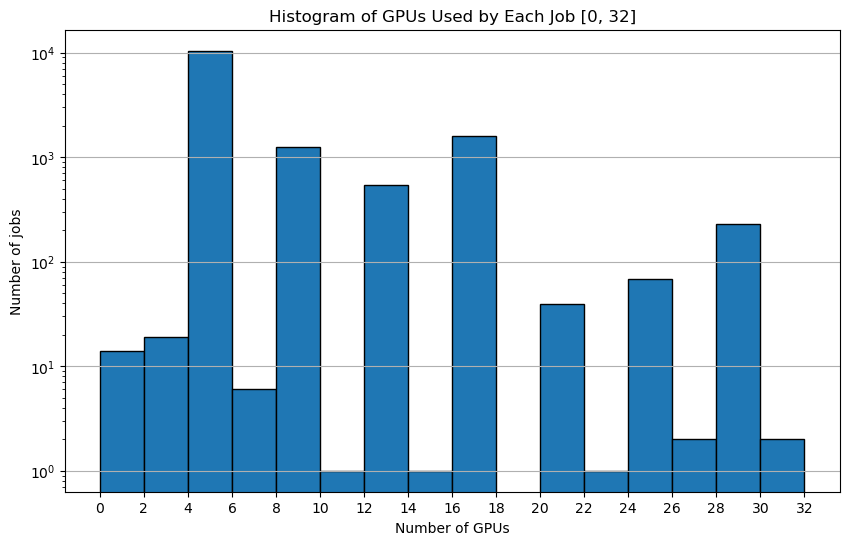

In [19]:
bins = list(range(0, 33, 2)) 

plt.figure(figsize=(10, 6))
plt.hist(total_gpus_less_32['total_gpus'], bins=bins, edgecolor='black')
plt.title('Histogram of GPUs Used by Each Job [0, 32]')
plt.xlabel('Number of GPUs')
plt.ylabel('Number of jobs')
plt.xticks(bins)  
plt.yscale('log') 
plt.grid(axis='y')
# plt.xticks(rotation=90)
plt.show()

In [20]:
jobs_with_g_per_node_1 = (jobs_with_g.groupby(['jobid', 'ProducerName'])
          .apply(lambda x: x[['gpu_id']]
                 .drop_duplicates()
                 .count())
          [["gpu_id"]]
         )
total_gpus_per_job = jobs_with_g_per_node_1.groupby('jobid').sum()

print(total_gpus_per_job)

          gpu_id
jobid           
13637517       1
13637520       1
13829694     276
13889527      80
13889532      80
...          ...
14068349       4
14068350    1024
14068352       4
14068358       4
14068359       4

[16144 rows x 1 columns]


In [21]:
total_gpus_per_job = total_gpus_per_job.reset_index().reset_index()
print(total_gpus_per_job[total_gpus_per_job["jobid"] == 14049391])
total_gpus_per_job

       index     jobid  gpu_id
12988  12988  14049391     320


,index,jobid,gpu_id
0,0,13637517,1
1,1,13637520,1
2,2,13829694,276
3,3,13889527,80
4,4,13889532,80
...,...,...,...
16139,16139,14068349,4
16140,16140,14068350,1024
16141,16141,14068352,4
16142,16142,14068358,4


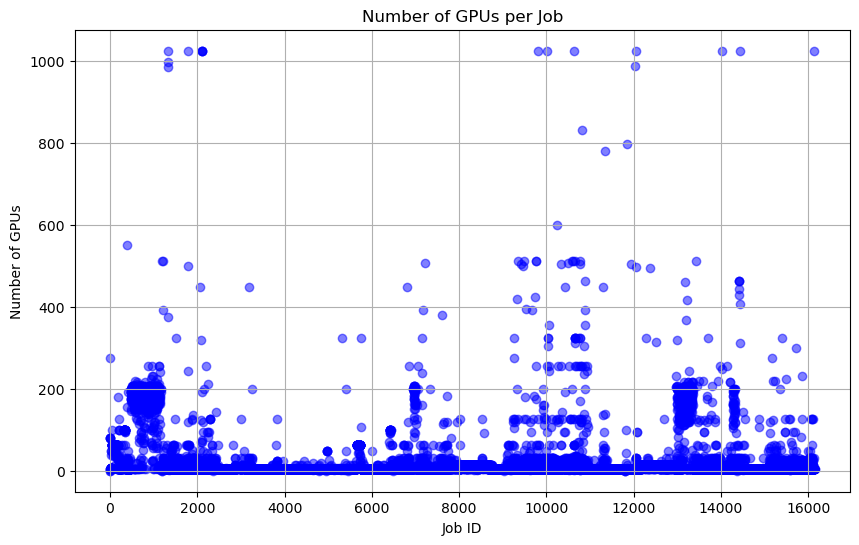

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(total_gpus_per_job['index'], total_gpus_per_job['gpu_id'], color='blue', alpha=0.5)
plt.title('Number of GPUs per Job')
plt.xlabel('Job ID')
plt.ylabel('Number of GPUs')
plt.grid(True)
plt.show()

### Number of GPUs per node

- Distribution of the number of GPUs used per node, with the y-axis on a logarithmic scale.
- The height of each bar represents the number of nodes that use a specific range of GPUs.
- <b> Most nodes utilize all four GPUs. This can be a good reason to analyze NVLink usage.

In [42]:
gpus_per_node

,jobid,ProducerName,gpus_per_node
0,13637517,login21,1
1,13637520,login35,1
2,13829694,nid001408,4
3,13829694,nid001409,4
4,13829694,nid001412,4
...,...,...,...
94468,14068350,nid004052,4
94469,14068350,nid004053,4
94470,14068352,nid001044,4
94471,14068358,nid001501,4


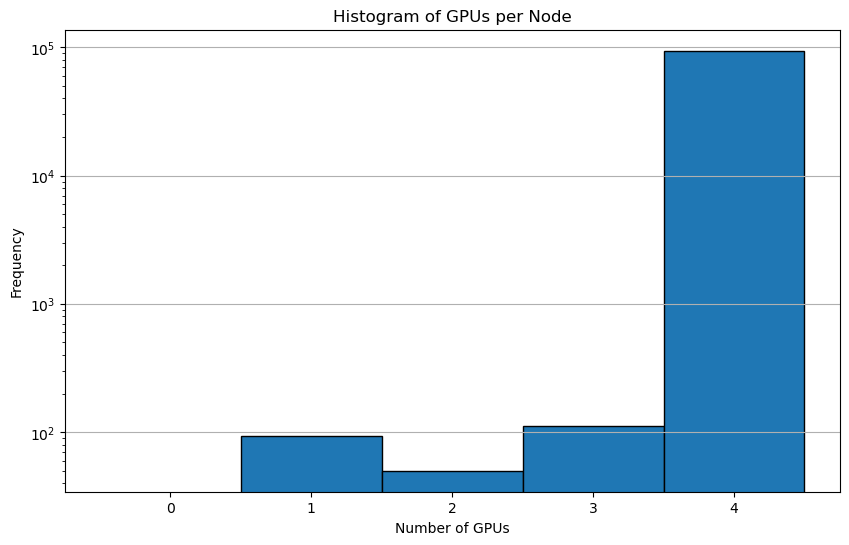

In [47]:
bins = [0, 1, 2, 3, 4, 5] 

plt.figure(figsize=(10, 6))
plt.hist(gpus_per_node['gpus_per_node'], bins=bins, edgecolor='black', align='left')
plt.title('Histogram of GPUs per Node')
plt.xlabel('Number of GPUs')
plt.ylabel('Frequency')
plt.xticks(range(0, 5))
plt.yscale('log')
plt.grid(axis='y')
plt.show()

### Distribution of node hours per job

In [23]:
job_durations = jobs_with_g[['jobid', 'duration']].drop_duplicates()
node_counts_with_duration = node_counts.merge(job_durations, on='jobid', how='left')
node_counts_with_duration['duration_hours'] = node_counts_with_duration['duration'].dt.total_seconds() / 3600
node_counts_with_duration['node_hours'] = node_counts_with_duration['duration_hours'] * node_counts_with_duration['unique_nodes']
node_counts_with_duration

,jobid,unique_nodes,duration,duration_hours,node_hours
0,13637517,1,0 days 05:04:46,5.079444,5.079444
1,13637520,1,0 days 05:04:47,5.079722,5.079722
2,13829694,69,0 days 01:50:56,1.848889,127.573333
3,13829694,69,0 days 01:50:14,1.837222,126.768333
4,13829694,69,0 days 01:50:42,1.845000,127.305000
...,...,...,...,...,...
41366,14068352,1,0 days 00:04:39,0.077500,0.077500
41367,14068352,1,0 days 00:03:46,0.062778,0.062778
41368,14068358,1,0 days 00:04:25,0.073611,0.073611
41369,14068358,1,0 days 00:04:06,0.068333,0.068333


In [24]:
node_counts_with_duration["node_hours"].max()

1152.2533333333333

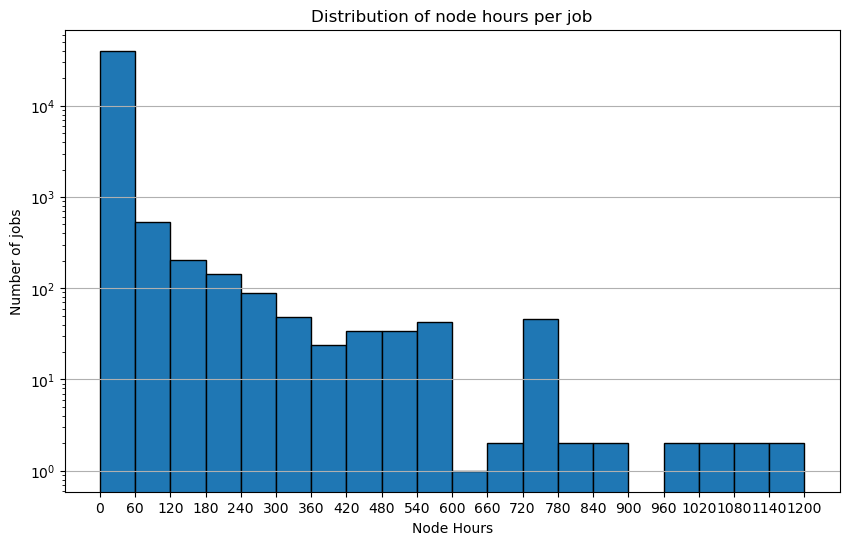

In [25]:
bins = list(range(0, 1201, 60)) 

plt.figure(figsize=(10, 6))
plt.hist(node_counts_with_duration['node_hours'], bins=bins, edgecolor='black')
plt.title('Distribution of node hours per job')
plt.xlabel('Node Hours')
plt.ylabel('Number of jobs')
plt.xticks(bins)  
plt.yscale('log') 
plt.grid(axis='y')
# plt.xticks(rotation=90)
plt.show()

### Number of jobs per node

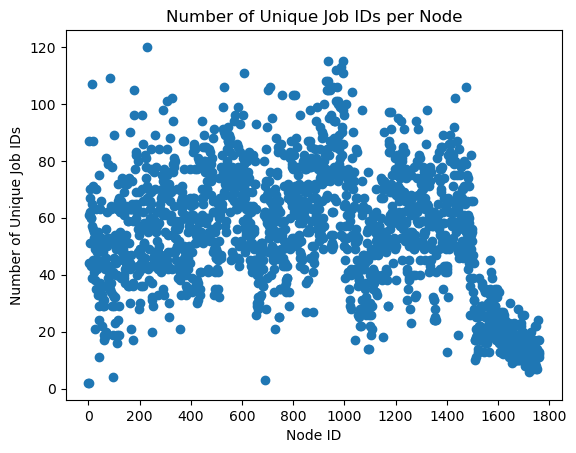

In [40]:
unique_job_counts = jobs_with_g.groupby('ProducerName')['jobid'].nunique()

unique_job_counts = unique_job_counts.reset_index().reset_index()

unique_job_counts.columns = ['index', 'ProducerName', 'unique_jobid_count']

plt.scatter(unique_job_counts['index'], unique_job_counts['unique_jobid_count'])
plt.title('Number of Unique Job IDs per Node')
plt.xlabel('Node ID')
plt.ylabel('Number of Unique Job IDs')
plt.xticks(ticks=range(0, 2000, 200))

plt.show()

### Number of jobs submitted each day

In [27]:
job_data = jobs_with_g.groupby('jobid').agg({
    'duration': 'first',
    'start_time': 'first',
    'end_time': 'first'
}).reset_index()

job_data['start_time'] = pd.to_datetime(job_data['start_time'])
job_data['end_time'] = pd.to_datetime(job_data['end_time'])
job_data['submit_date'] = job_data['start_time'].dt.date
daily_job_counts = job_data.groupby('submit_date').size()

print(daily_job_counts)

submit_date
2023-08-16    1639
2023-08-17    8203
2023-08-18    5011
2023-08-19    1291
dtype: int64


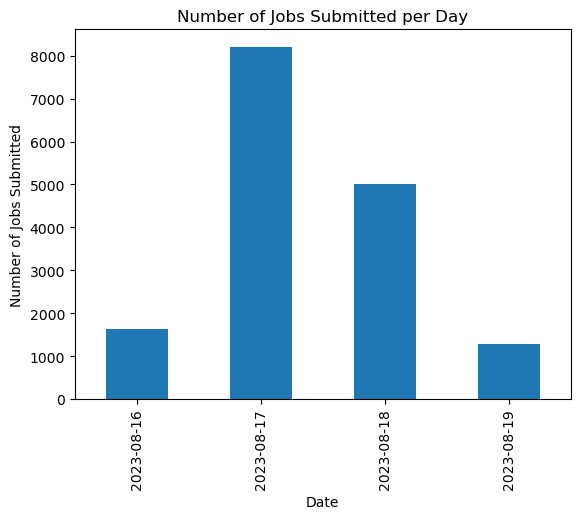

In [28]:
daily_job_counts.plot(kind='bar')
plt.title('Number of Jobs Submitted per Day')
plt.xlabel('Date')
plt.ylabel('Number of Jobs Submitted')
plt.show()

### Job submissions by hour of the day and day of the week

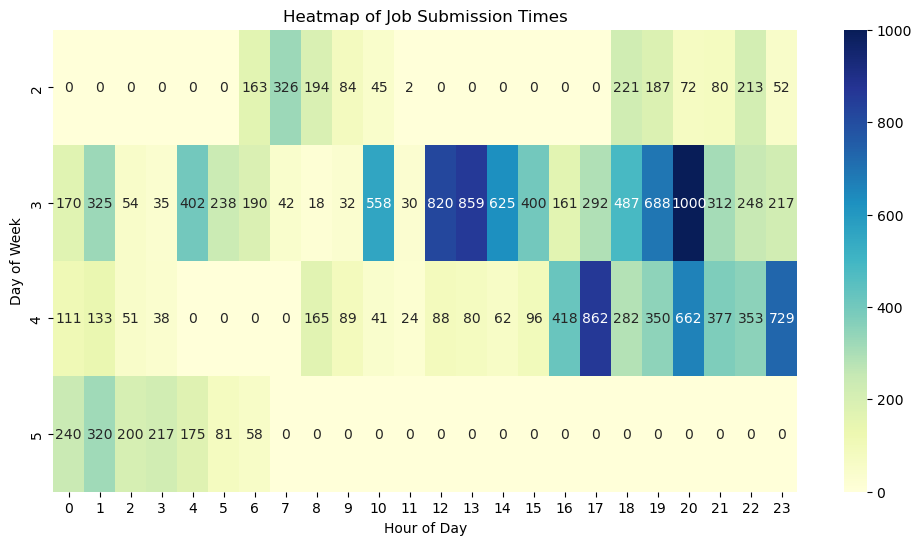

In [29]:
job_data['submit_hour'] = job_data['start_time'].dt.hour
job_data['submit_day'] = job_data['start_time'].dt.dayofweek

submit_heatmap_data = job_data.pivot_table(index='submit_day', columns='submit_hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(submit_heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Heatmap of Job Submission Times')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

### Number of jobs submitted per Account

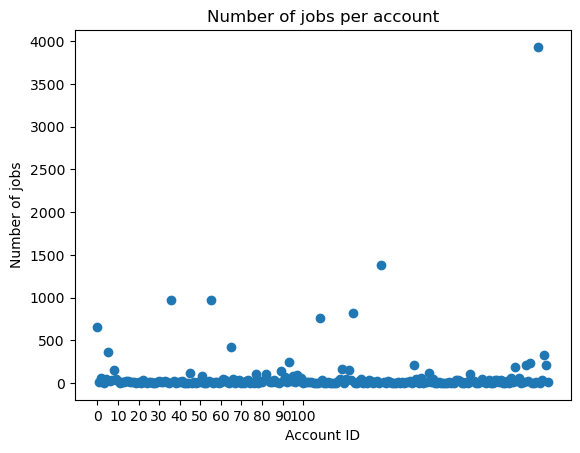

In [30]:
unique_job_counts_per_account = jobs_with_g.groupby('Account')['jobid'].nunique()
unique_job_counts_per_account = unique_job_counts_per_account.reset_index().reset_index()

unique_job_counts_per_account.columns = ['index', 'ProducerName', 'unique_job_counts_per_account']

plt.scatter(unique_job_counts_per_account['index'], unique_job_counts_per_account['unique_job_counts_per_account'])
plt.title('Number of jobs per account')
plt.xlabel('Account ID')
plt.ylabel('Number of jobs')
plt.xticks(ticks=range(0, 110, 10))

plt.show()

In [31]:
unique_job_counts_per_account.sort_values("unique_job_counts_per_account")

,index,ProducerName,unique_job_counts_per_account
42,42,m2401_g,1
140,140,m4137_g,1
21,21,m1338_g,1
74,74,m3210_g,1
192,192,m499_g,1
...,...,...,...
124,124,m4033_g,821
36,36,m2113_g,968
55,55,m2755_g,972
138,138,m4129_g,1377


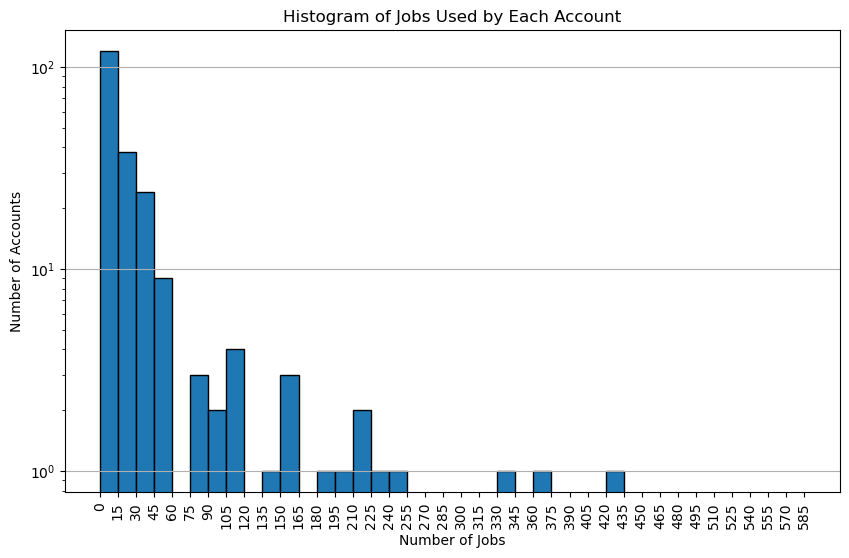

In [32]:
bins = list(range(0, 600, 15))  # Bins from 0 to 256, step by 16

plt.figure(figsize=(10, 6))
plt.hist(unique_job_counts_per_account['unique_job_counts_per_account'], bins=bins, edgecolor='black')
plt.title('Histogram of Jobs Used by Each Account')
plt.xlabel('Number of Jobs')
plt.ylabel('Number of Accounts')
plt.xticks(bins, rotation=90)  
plt.yscale('log') 
plt.grid(axis='y')
plt.show()

### Node hours used per Account

In [33]:
job_data = jobs_with_g.groupby('jobid').agg({
    'Account': 'first',
    'SubmitLine': 'first',
    'start_time': 'first',
    'end_time': 'first',
    'nnodes': 'first'
}).reset_index()

In [34]:
job_data['job_duration_hours'] = (job_data['end_time'] - job_data['start_time']).dt.total_seconds() / 3600
job_data['node_hours'] = job_data['nnodes'] * job_data['job_duration_hours']
average_node_hours_per_account = job_data.groupby('Account')['node_hours'].mean()
average_node_hours_per_account

Account
als_g          2.388124
atlas_g        4.394960
dasrepo_g      1.003229
deepsrch_g     3.626250
des_g          1.302720
                ...    
mpcray_g      42.858889
nintern_g      0.019041
ntrain1_g      0.186305
ntrain_g       1.451217
nyx_g          1.580357
Name: node_hours, Length: 220, dtype: float64

In [35]:
print(average_node_hours_per_account.max())

268.19944444444445


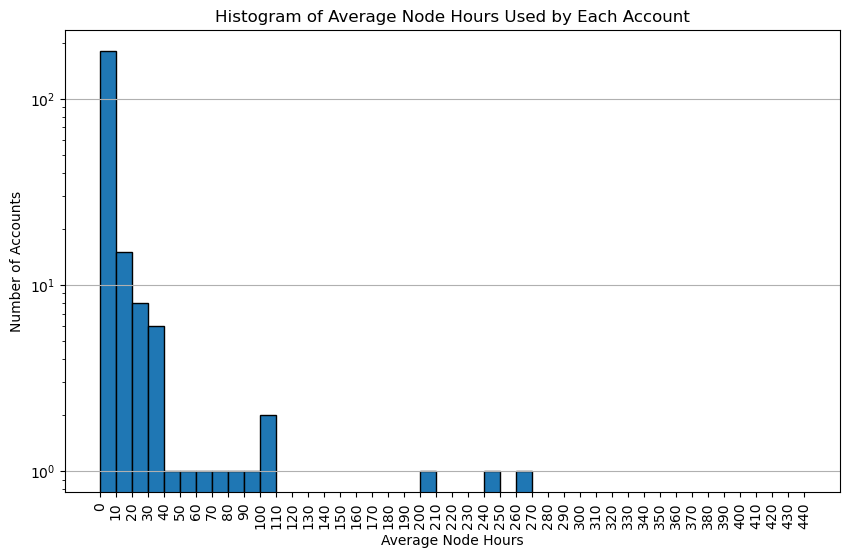

In [36]:
bins = list(range(0, 450, 10))

plt.figure(figsize=(10, 6))
plt.hist(average_node_hours_per_account, bins=bins, edgecolor='black')
plt.title('Histogram of Average Node Hours Used by Each Account')
plt.xlabel('Average Node Hours')
plt.ylabel('Number of Accounts')
plt.xticks(bins)
plt.yscale('log')  
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.show()

### Count the number of deep learning applications
- We can use this to compare resource usage of deep learning apps with others

In [37]:
deep_learning_keywords = [
    'epoch', 'batch', 'training', 'neural', 'model', 'cnn', 'rnn', 'lstm', 
    'transformer', 'bert', 'tensorflow', 'pytorch', 'keras', 'deep', 'learning', 
    'ai', 'machine', 'ml'
]

job_data = jobs_with_g.groupby('jobid').agg({
    'SubmitLine': 'first',
    'JobName': 'first',
}).reset_index()

def is_deep_learning_application(row):
    text = f"{row['SubmitLine']} {row['JobName']}".lower()
    return any(keyword in text for keyword in deep_learning_keywords)

job_data['is_deep_learning'] = job_data.apply(is_deep_learning_application, axis=1)
deep_learning_job_count = job_data['is_deep_learning'].sum()
print("The total number of jobs: ", len(job_data))
print("Deep learning jobs: ", deep_learning_job_count)

The total number of jobs:  16144
Deep learning jobs:  6073


### Ignore the rest. WIP.

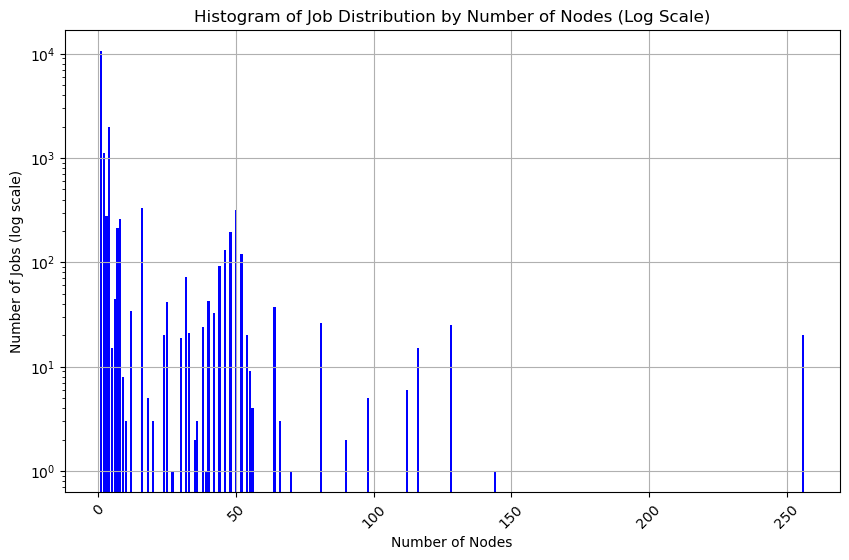

In [24]:
job_node_data = jobs_with_g[["jobid", "nnodes"]].drop_duplicates()
# Counting how many jobs use each number of nodes
node_counts = job_node_data['nnodes'].value_counts()

# Sorting the index for better readability (optional, but helps in understanding the distribution)
node_counts_sorted = node_counts.sort_index()

plt.figure(figsize=(10, 6))
plt.bar(node_counts_sorted.index, node_counts_sorted.values, color='blue')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Jobs (log scale)')
plt.title('Histogram of Job Distribution by Number of Nodes (Log Scale)')
plt.xticks(rotation=45)
plt.yscale('log')  # Applying log scale to the y-axis
plt.grid(True)

# Show the plot
plt.show()

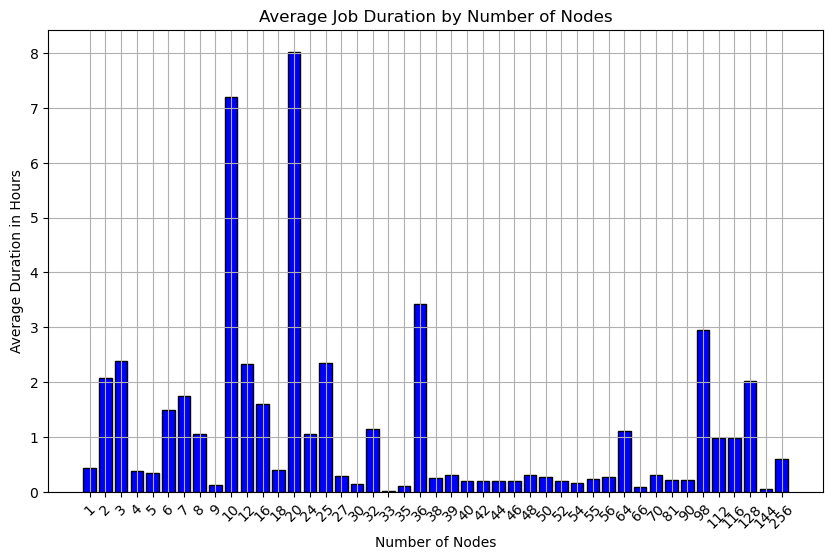

In [69]:
job_node_hour_data = jobs_with_g[["jobid", "nnodes", "duration"]].drop_duplicates()
job_node_hour_data['duration_hours'] = job_node_hour_data['duration'].dt.total_seconds() / 3600.0

# Calculate the average duration in hours by number of nodes
average_duration_by_nodes = job_node_hour_data.groupby('nnodes')['duration_hours'].mean()
average_duration_values = average_duration_by_nodes.values

plt.figure(figsize=(10, 6))
plt.bar(average_duration_by_nodes.index.astype(str), average_duration_by_nodes.values, color='blue', edgecolor='black')
plt.xlabel('Number of Nodes')
plt.ylabel('Average Duration in Hours')
plt.title('Average Job Duration by Number of Nodes')
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [37]:
# Define the keywords as a regular expression
keywords = r'training|batch|epoch'

# Count the number of rows that contain any of the keywords in the SubmitLine column
count_matches = jobs_with_g['SubmitLine'].drop_duplicates().str.contains(keywords, case=False, na=False).sum()

# Print the result
print(f"Number of rows containing the keywords: {count_matches}")

Number of rows containing the keywords: 239


/tmp/ipykernel_1487497/2759603340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_with_g['duration_hours'] = jobs_with_g['duration'].dt.total_seconds() / 3600


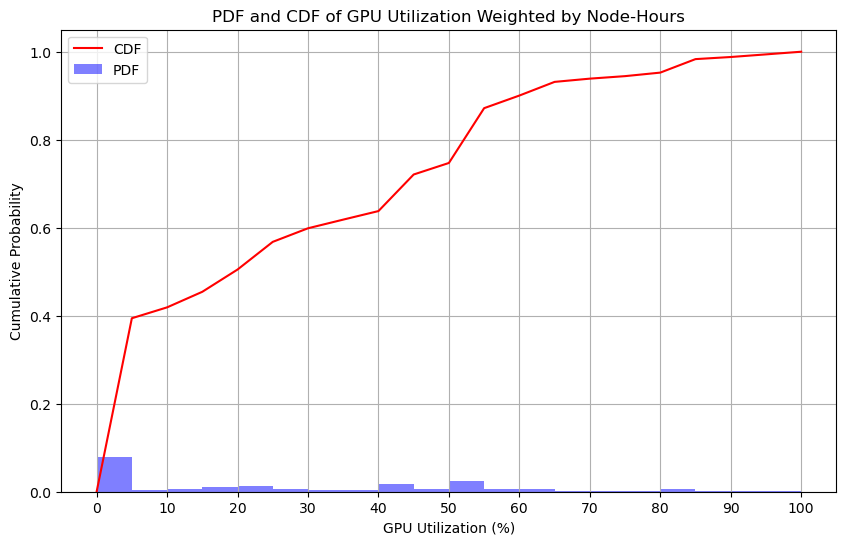

In [90]:
# Convert 'duration' from timedelta to hours
jobs_with_g['duration_hours'] = jobs_with_g['duration'].dt.total_seconds() / 3600

# Aggregate data: summing durations might not make sense unless they overlap; averaging utilization does
aggregated_data = jobs_with_g.groupby('jobid').agg({
    'nnodes': 'first',  # Assuming nnodes is the same for all entries of the same job
    'duration_hours': 'first',  # Assuming duration is the same for all entries of the same job
    'gpu_utilization': 'mean'  # Average the GPU utilization across multiple entries
})

# Now calculate node-hours by multiplying duration by nnodes
aggregated_data['node_hours'] = aggregated_data['duration_hours'] * aggregated_data['nnodes']

# Creating a new DataFrame for weighted GPU utilization
weighted_gpu_utilization = pd.DataFrame({
    'gpu_utilization': aggregated_data['gpu_utilization'],
    'weight': aggregated_data['node_hours']
})

# Define bins for every 5% interval
bins = np.linspace(0, 100, 21)  # Creates 20 bins (two bins per each 10% interval)

# Calculate histogram data for PDF (for visualization only, not used in CDF calculation)
pdf_values, pdf_base = np.histogram(weighted_gpu_utilization['gpu_utilization'], bins=bins, weights=weighted_gpu_utilization['weight'], density=True)
pdf_widths = np.diff(pdf_base)
pdf_centers = pdf_base[:-1] + pdf_widths / 2

# Calculate CDF directly from data
cdf_values, _ = np.histogram(weighted_gpu_utilization['gpu_utilization'], bins=bins, weights=weighted_gpu_utilization['weight'])
cdf_values = np.cumsum(cdf_values)  # Cumulative sum of counts or weights
cdf_values = np.insert(cdf_values, 0, 0)  # Inserting 0 at the beginning for the CDF start
cdf_values = cdf_values / cdf_values[-1]  # Normalize to get CDF

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(pdf_centers, pdf_values, width=pdf_widths, color='blue', alpha=0.5, label='PDF')
plt.plot(pdf_base, cdf_values, color='red', label='CDF')  # Use pdf_base which includes the last bin edge
plt.xlabel('GPU Utilization (%)')
plt.ylabel('Cumulative Probability')
plt.title('PDF and CDF of GPU Utilization Weighted by Node-Hours')
plt.xticks(np.arange(0, 101, 10))
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [100]:
jobs_with_g[["gpu_utilization", "duration", "jobid", "nnodes", "gpu_id", "ProducerName"]]

,gpu_utilization,duration,jobid,nnodes,gpu_id,ProducerName
2088732,0.0,0 days 05:04:46,13637517,1,0,login21
2088733,0.0,0 days 05:04:46,13637517,1,0,login21
2088734,0.0,0 days 05:04:46,13637517,1,0,login21
2088735,0.0,0 days 05:04:46,13637517,1,0,login21
2088736,0.0,0 days 05:04:46,13637517,1,0,login21
...,...,...,...,...,...,...
52268356,0.0,0 days 00:15:28,14049391,81,1,nid008701
52268357,0.0,0 days 00:15:28,14049391,81,0,nid008701
52268358,0.0,0 days 00:15:28,14049391,81,3,nid008701
52268359,0.0,0 days 00:15:28,14049391,81,2,nid008701


In [111]:
jobs_with_g[jobs_with_g["jobid"] == 14049391].groupby("ProducerName")["gpu_id"].count()

ProducerName
nid001224    4384
nid001477    4343
nid001548    4182
nid001572    4323
nid001584    4313
             ... 
nid008677      48
nid008684     176
nid008697     216
nid008700     268
nid008701     184
Name: gpu_id, Length: 80, dtype: int64

In [117]:
jobs_with_g_per_node_1 = (jobs_with_g.groupby(['jobid', 'ProducerName'])
          .apply(lambda x: x[['gpu_id']]
                 .drop_duplicates()
                 .count())
          [["gpu_id"]]
         )
# Sum the number of GPUs for each job across all nodes
total_gpus_per_job = jobs_with_g_per_node_1.groupby('jobid').sum()

# Display the result
print(total_gpus_per_job)

          gpu_id
jobid           
13637517       1
13637520       1
13829694     220
13889527      80
13889537      40
...          ...
14068349       4
14068350     948
14068352       4
14068358       4
14068359       4

[14596 rows x 1 columns]


In [120]:
total_gpus_per_job = total_gpus_per_job.reset_index()
print(total_gpus_per_job[total_gpus_per_job["jobid"] == 14049391])
total_gpus_per_job

       index     jobid  gpu_id
11811  11811  14049391     320


,index,jobid,gpu_id
0,0,13637517,1
1,1,13637520,1
2,2,13829694,220
3,3,13889527,80
4,4,13889537,40
...,...,...,...
14591,14591,14068349,4
14592,14592,14068350,948
14593,14593,14068352,4
14594,14594,14068358,4


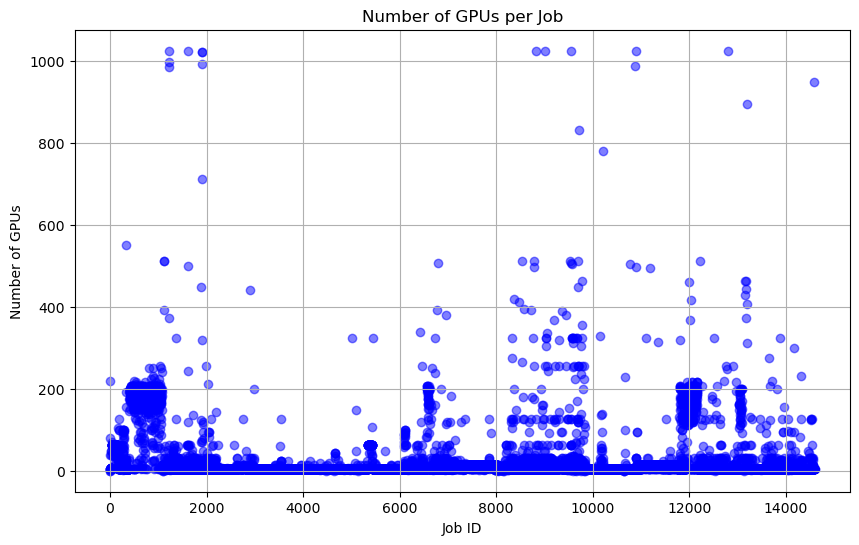

In [122]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(total_gpus_per_job['index'], total_gpus_per_job['gpu_id'], color='blue', alpha=0.5)
plt.title('Number of GPUs per Job')
plt.xlabel('Job ID')
plt.ylabel('Number of GPUs')
plt.grid(True)
plt.show()

In [124]:
# Since it appears total_gpus_per_job has an unnecessary 'index' column, ensure 'jobid' is set properly
total_gpus_per_job.set_index('index', inplace=True)

# Merge the DataFrames on 'jobid'
merged_data = pd.merge(job_node_hour_data, total_gpus_per_job, on='jobid', how='left')

# Now, merged_data will have the gpu_id values where jobids match
print(merged_data)

          jobid  nnodes        duration  duration_hours  gpu_id
0      13637517       1 0 days 05:04:46        5.079444       1
1      13962218       1 2 days 12:45:52       60.764444       1
2      13637520       1 0 days 05:04:47        5.079722       1
3      13962219       1 2 days 12:45:52       60.764444       1
4      13966584       1 0 days 00:07:46        0.129444       4
...         ...     ...             ...             ...     ...
35512  13901123       1 0 days 00:03:22        0.056111       4
35513  13901123       1 0 days 00:02:40        0.044444       4
35514  13968208       1 0 days 00:20:57        0.349167       4
35515  13968208       1 0 days 00:05:05        0.084722       4
35516  14026790       1 0 days 00:36:54        0.615000     380

[35517 rows x 5 columns]


aries-perf-variation	       imagenet        loimos-perf
baustin			       io-experiments  parallel_deep_learning
cori-perf-variation	       io-performance  performance-portability
cori-perf-variation-features   jyeom	       pristine-raw-data
cori-perf-variation-mlscripts  jyeom-scn       trash
cori-perf-variation-prerun     LDAV-2016       UMT
episimdemics		       loimos
